In [1]:
from pathlib import Path

import numpy as np
from zanj import ZANJ

from maze_dataset import MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators
from maze_dataset.benchmark.config_sweep import (
    SweepResult,
    full_percolation_analysis,
    dataset_success_fraction,
    plot_grouped,
)
from maze_dataset.benchmark.sweep_fit import sweep_fit

f:\KNC\maze-dataset\.venv\Lib\site-packages\juliacall\__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


# run a basic analysis

tqdm_allowed_kwargs = {'leave', 'mininterval', 'write_bytes', 'unit_divisor', 'disable', 'nrows', 'miniters', 'ncols', 'unit', 'desc', 'delay', 'ascii', 'position', 'unit_scale', 'total', 'postfix', 'smoothing', 'bar_format', 'lock_args', 'dynamic_ncols', 'gui', 'self', 'maxinterval', 'file', 'initial', 'iterable', 'colour'}
mapped_kwargs = {'total': 3, 'desc': 'Processing 3 items'}


Processing 3 items: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


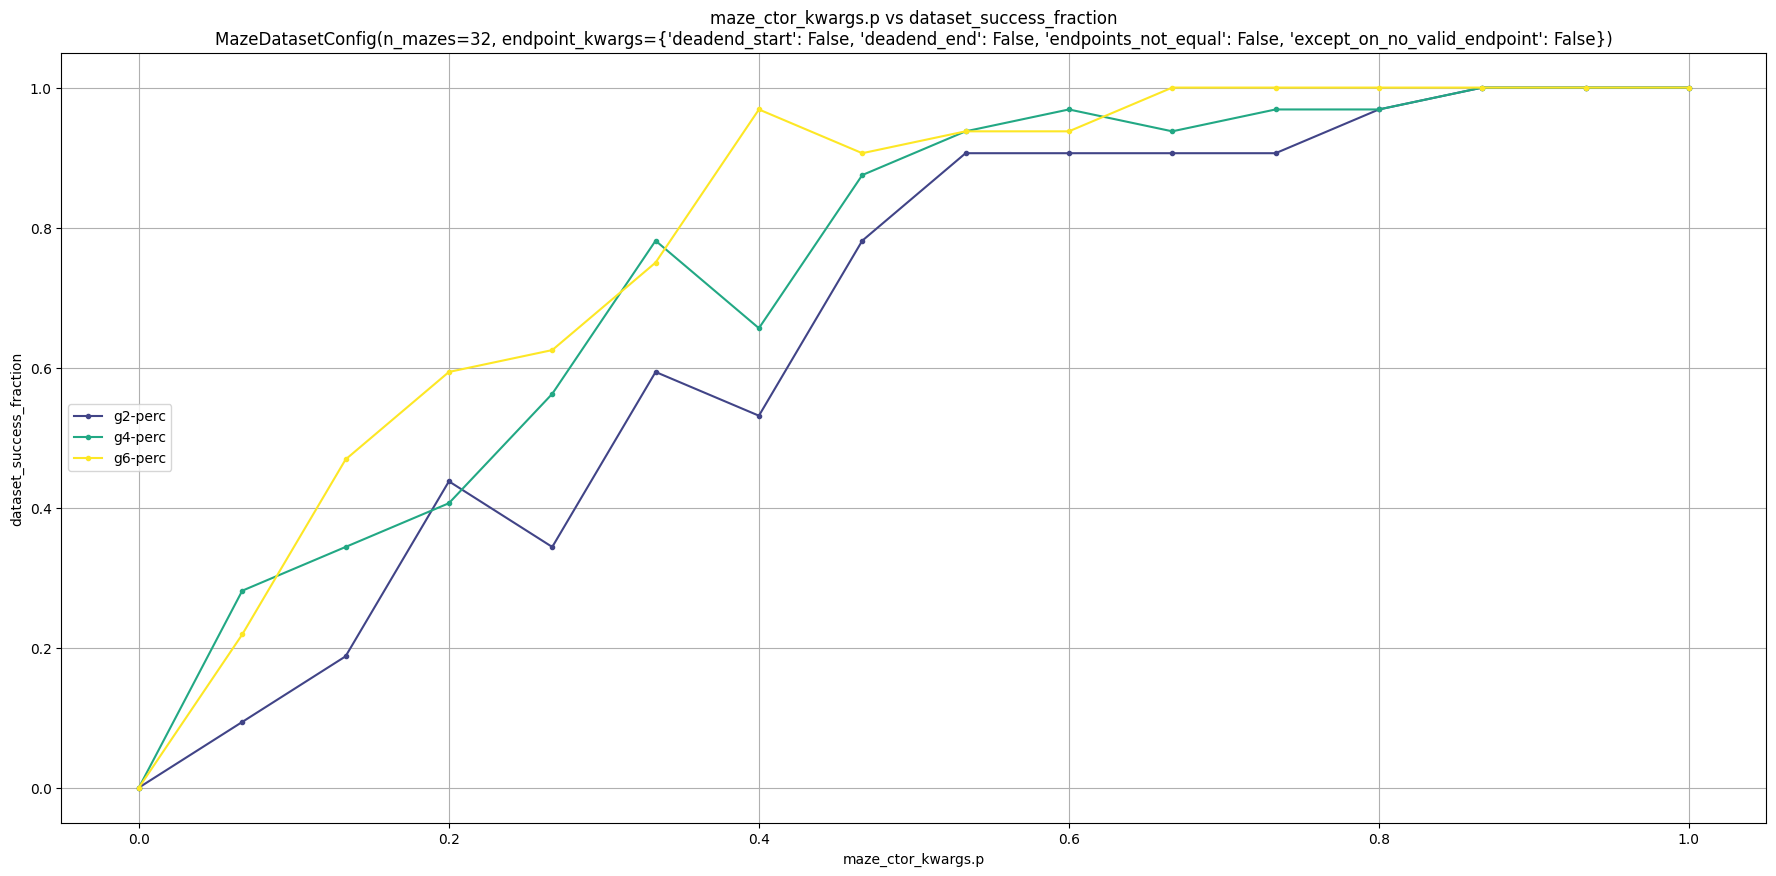

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [2]:
# Run the analysis
results: SweepResult = SweepResult.analyze(
    configs=[
        MazeDatasetConfig(
            name=f"g{grid_n}-perc",
            grid_n=grid_n,
            n_mazes=32,
            maze_ctor=LatticeMazeGenerators.gen_percolation,
            maze_ctor_kwargs=dict(),
            endpoint_kwargs=dict(
                deadend_start=False,
                deadend_end=False,
                endpoints_not_equal=False,
                except_on_no_valid_endpoint=False,
            ),
        )
        for grid_n in [2, 4, 6]
    ],
    param_values=np.linspace(0.0, 1.0, 16).tolist(),
    param_key="maze_ctor_kwargs.p",
    analyze_func=dataset_success_fraction,
    parallel=False,
)

# Plot results
results.plot(save_path=None, cfg_keys=["n_mazes", "endpoint_kwargs"])


## check saving/loading

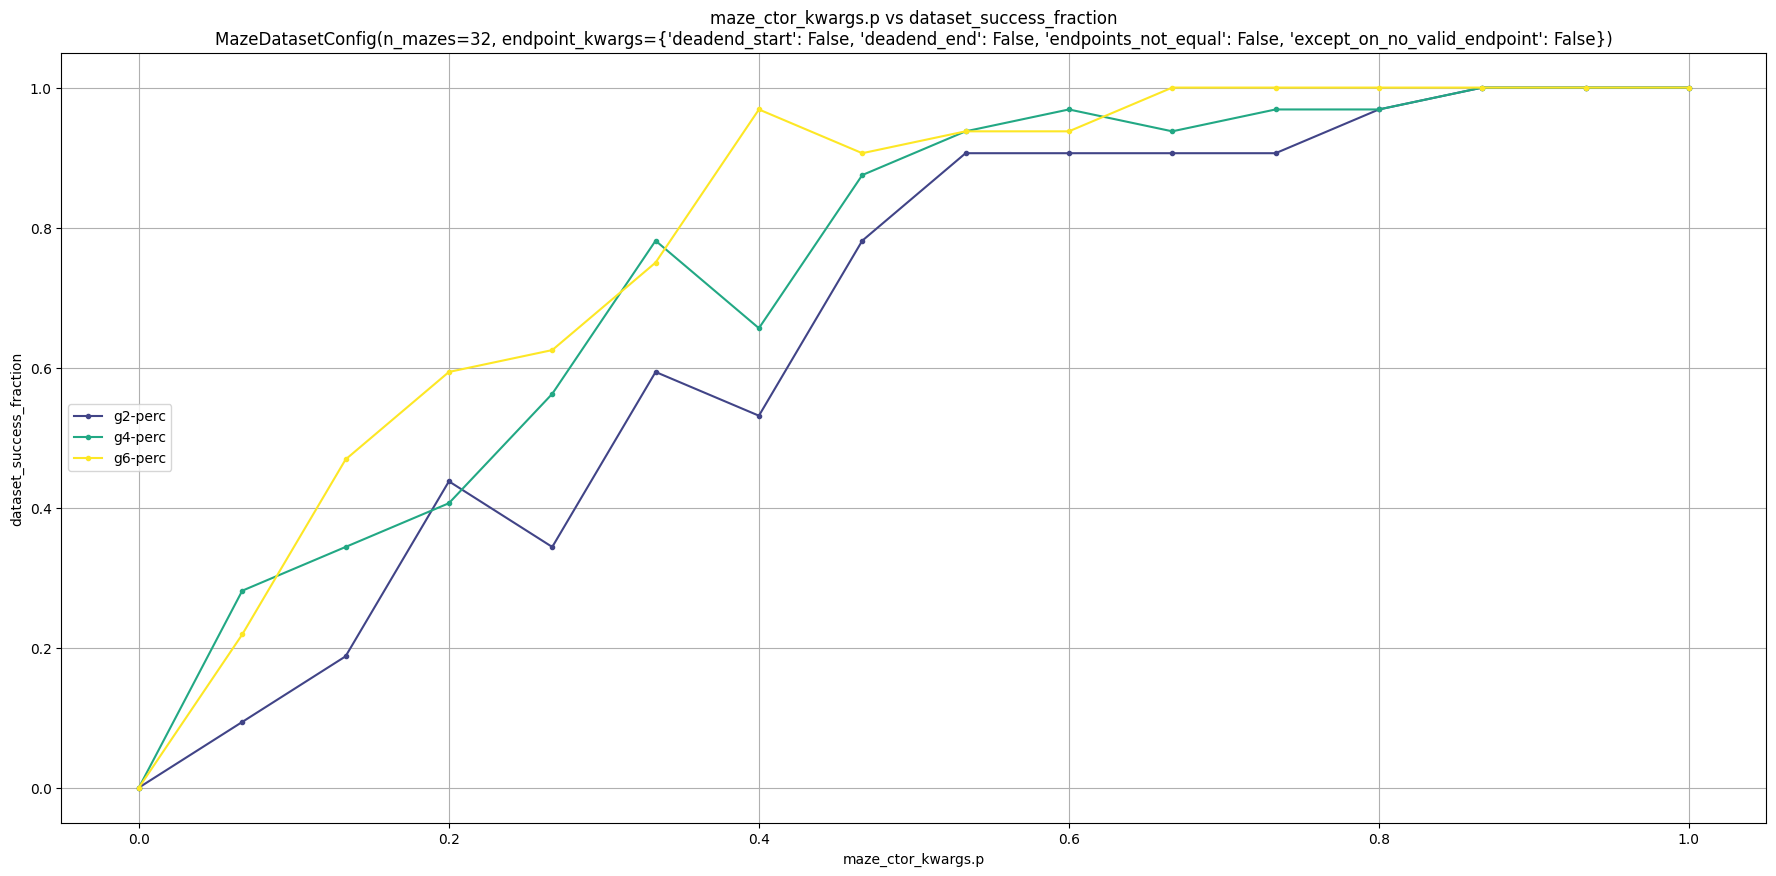

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [3]:
path = Path("../tests/_temp/dataset_frac_sweep/results_small.zanj")
results.save(path)
ZANJ().read(path).plot(cfg_keys=["n_mazes", "endpoint_kwargs"])

# sweep acrossall endpoint kwargs and generator funcs 

In [4]:
results_sweep: SweepResult = full_percolation_analysis(
    n_mazes=16,
    p_val_count=16,
    grid_sizes=[2, 4, 6],
    parallel=False,
)

tqdm_allowed_kwargs = {'leave', 'mininterval', 'write_bytes', 'unit_divisor', 'disable', 'nrows', 'miniters', 'ncols', 'unit', 'desc', 'delay', 'ascii', 'position', 'unit_scale', 'total', 'postfix', 'smoothing', 'bar_format', 'lock_args', 'dynamic_ncols', 'gui', 'self', 'maxinterval', 'file', 'initial', 'iterable', 'colour'}
mapped_kwargs = {'total': 18, 'desc': 'Processing 18 items'}


Processing 18 items: 100%|██████████| 18/18 [00:13<00:00,  1.33it/s]


Saving results to ../docs/benchmarks/percolation_fractions/result-n16-c18-p16.zanj


In [11]:
results_medium: SweepResult = SweepResult.read(
    "../docs/benchmarks/percolation_fractions/medium/result-n128-c42-p50.zanj"
)

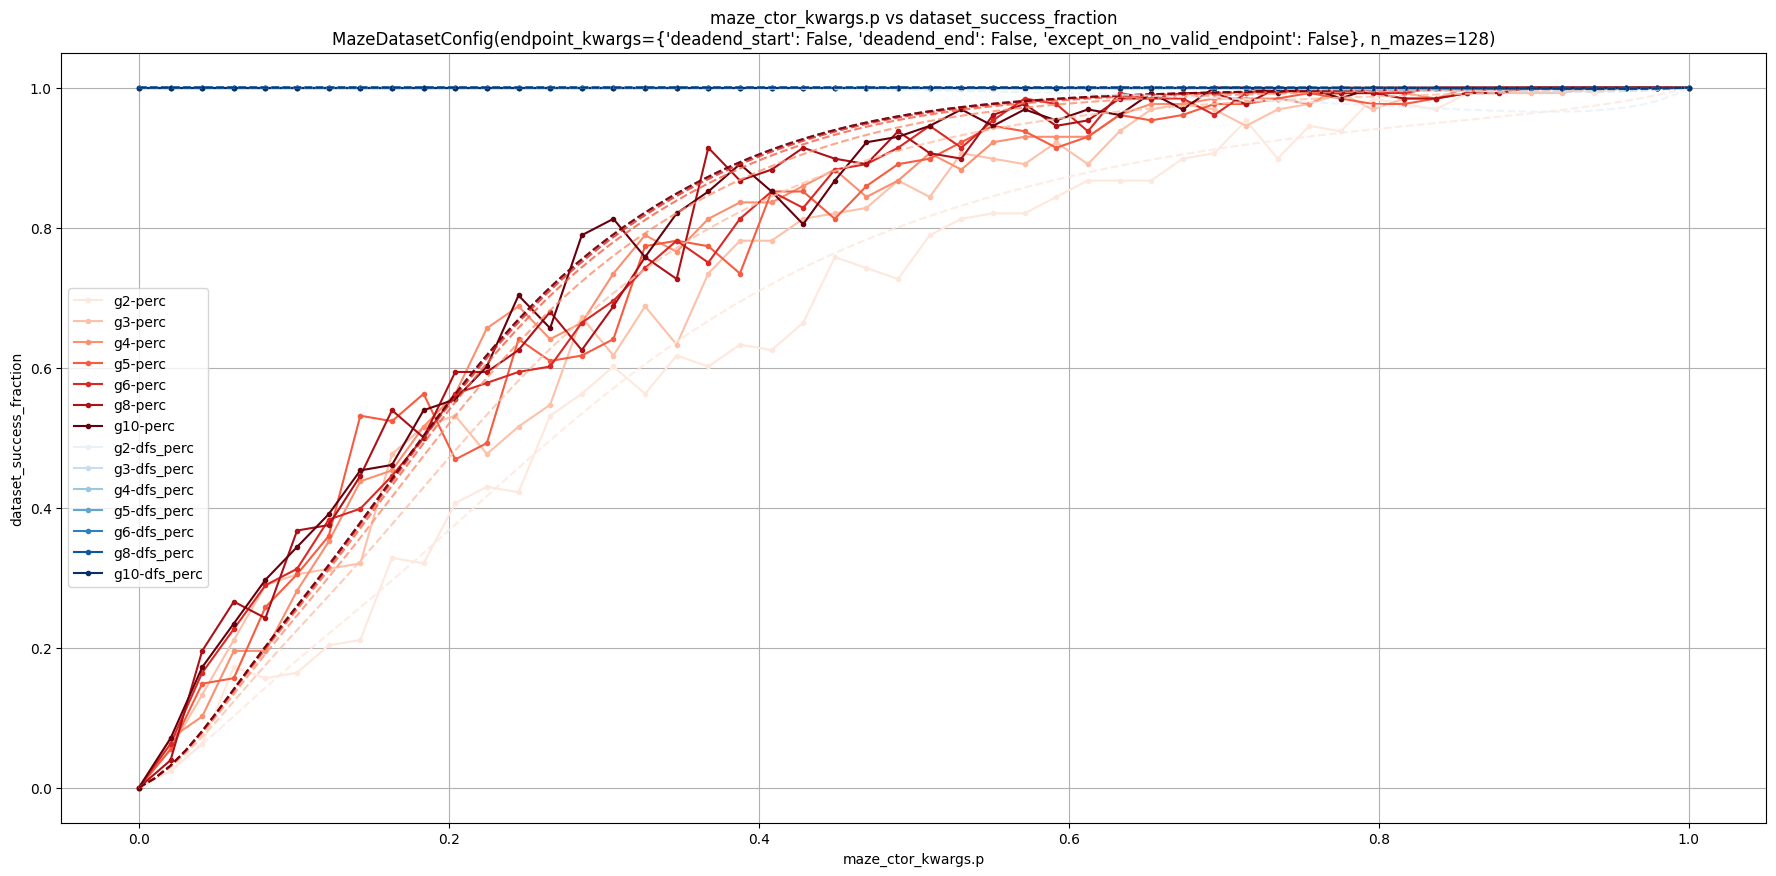

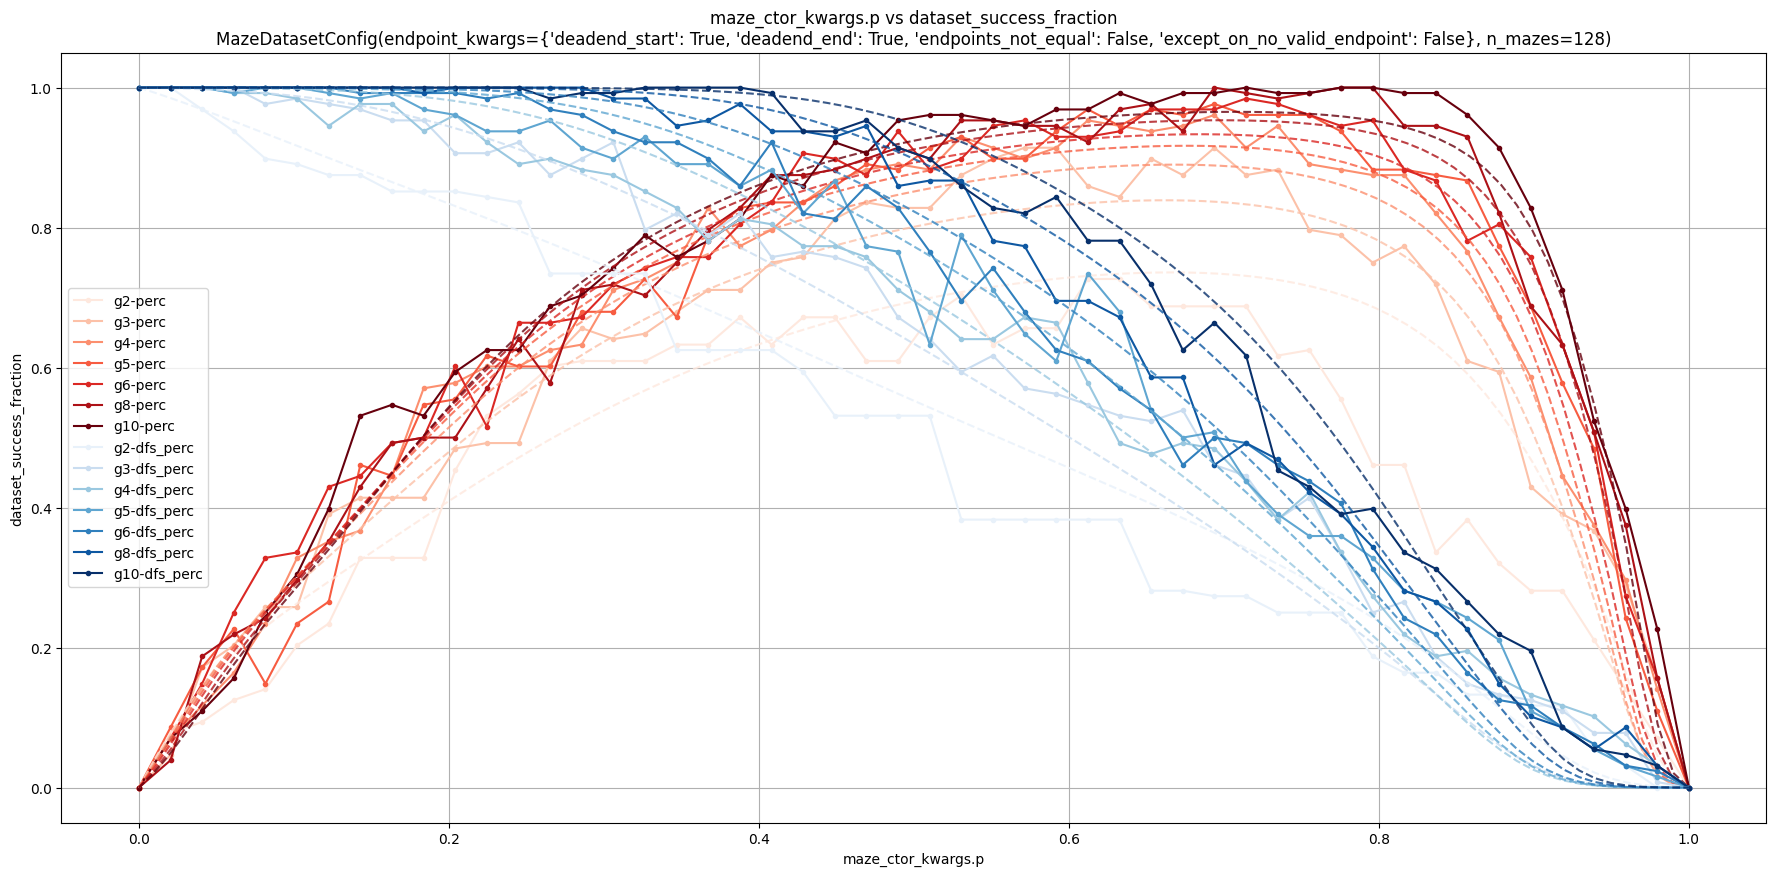

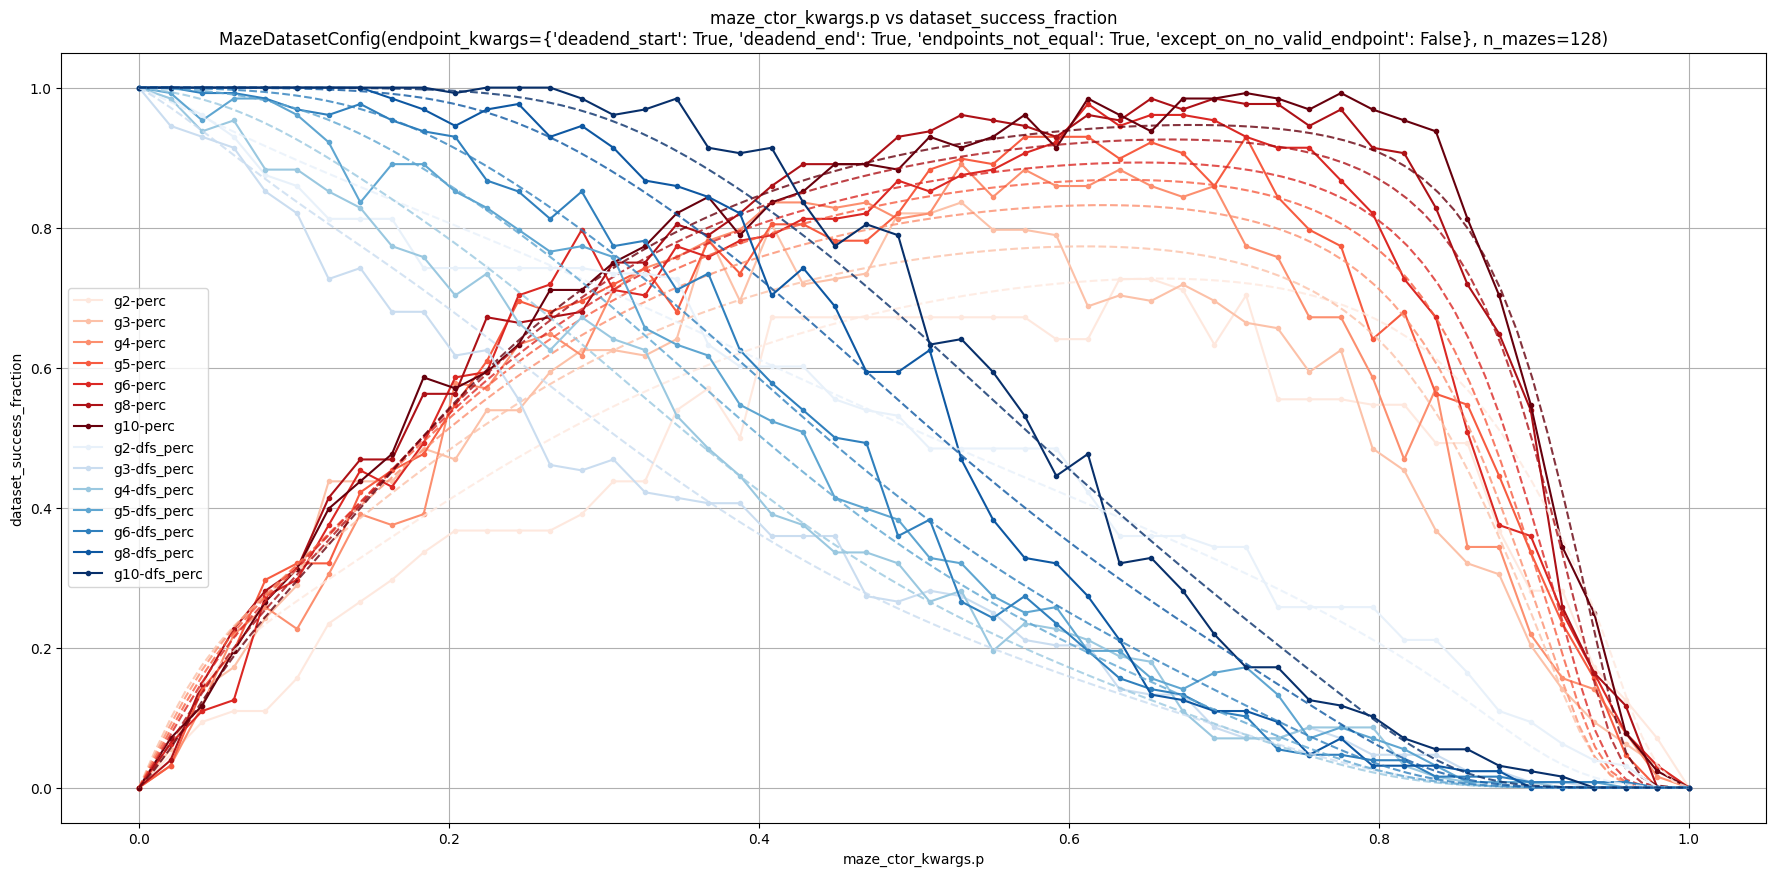

In [12]:
def sigmoid(x: float) -> float:
    return 1 / (1 + np.exp(-x))

"""
Desmos link: https://www.desmos.com/calculator/n928krkk24
"""

_s = lambda x: 1 / (1 + np.exp(-1000 * (x - 0.5)))
r"sigmoid(x)= 1 / (1 + e^{-b(x-0.5)})"

_g = lambda q, a: 1 - np.abs(2 * q - 1) ** a
r"g(q,a) = 1 - (|2q-1|)^{a}"

_f = lambda q, a: q * _g(q, a)
r"f(q,a) = q * g(q,a)"

_h = lambda q, a: _f(q, a) * (1 - _s(q)) + (1 - _f(1 - q, a)) * _s(q)
r"h(q,a,b) = f(q,a) * (1-s(q,b)) + (1-f(1-q,a)) * s(q,b)"

_A = lambda q, a, w: w * _g(q, a)
r"A(q) = b * g(q, a)"

def soft_step(
    x: float,
    p: float,
    alpha: float = 5,
    w: float = 50,
) -> float:
    return _h(
        x,
        _A(p, alpha, w),
    )

def predict_fn_test(cfg):
    x = cfg._to_ps_array()
    # return (sigmoid((np.exp((x[4] - x[0])**2) + (((x[0] + (x[0] - (sigmoid((x[2] * (x[3] * x[4])) + x[0])**(x[1]**0.6401807)))) * 1.3918748) - np.exp((x[0] * (x[2] + 0.30070293))**2))) * 3.048825))**2
    raw_val: float = sigmoid(
        (
            (
                ((sigmoid((x[1] - x[3]) ** 3) * -4.721228) - (x[3] * 1.4636494))
                * (
                    x[2]
                    * (
                        x[4]
                        + (((x[0] + 0.048765484) ** 9.746339) + (0.8998194 ** x[1]))
                    )
                )
            )
            + (2.4524326 ** (2.9501643 - x[0]))
        )
        * (
            (
                (((0.9077277 - x[0]) * ((x[4] * 1.0520288) ** x[1])) + x[0])
                * sigmoid(x[1]) ** 3
            )
            + -0.18268494
        )
    )
    # return raw_val
    return soft_step(
        x=raw_val,
        p=x[0],
        alpha=5,
        w=10,
    )


plot_grouped(results_medium, predict_fn=predict_fn_test, prediction_density=100)

# perform a pysr regression on a dataset we load

In [ ]:
DATA_PATH_DIR: Path = Path("../docs/benchmarks/percolation_fractions/")
# DATA_PATH: str = DATA_PATH_DIR / "large/result-n256-c54-p100.zanj"
# DATA_PATH: str = DATA_PATH_DIR / "medium/result-n128-c42-p50.zanj"
DATA_PATH: str = DATA_PATH_DIR / "small/result-n64-c30-p25.zanj"
# DATA_PATH: str = DATA_PATH_DIR / "test/result-n16-c12-p16.zanj"

sweep_fit(
    DATA_PATH,
    Path("../docs/benchmarks/percolation_fractions/fit_plots/"),
    niterations=10,
)

RuntimeError: No active exception to reraise

$$0.14936^{((x_0 - ((((x_0 * 0.94458)^{x_4})^2) - (x_2 \cdot (x_0^{(2.4176 - x_3)}))))^2 + 0.066666)^{(\ln(x_1 + 0.53705) + (-0.079823^{x_2})}}$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from ipywidgets import interact, FloatSlider, fixed, HBox, VBox, Layout
import ipywidgets as widgets
from typing import Callable, Tuple, Union, List

"""
Desmos link: https://www.desmos.com/calculator/n928krkk24
"""

_s = lambda x: 1 / (1 + np.exp(-1000 * (x - 0.5)))
r"sigmoid(x)= 1 / (1 + e^{-b(x-0.5)})"

_g = lambda q, a: 1 - np.abs(2 * q - 1) ** a
r"g(q,a) = 1 - (|2q-1|)^{a}"

_f = lambda q, a: q * _g(q, a)
r"f(q,a) = q * g(q,a)"

_h = lambda q, a: _f(q, a) * (1 - _s(q)) + (1 - _f(1 - q, a)) * _s(q)
r"h(q,a,b) = f(q,a) * (1-s(q,b)) + (1-f(1-q,a)) * s(q,b)"

_A = lambda q, a, w: w * _g(q, a)
r"A(q) = b * g(q, a)"

def soft_step(
    x: Union[float, np.ndarray],
    p: float,
    alpha: float,
    w: float,
) -> Union[float, np.ndarray]:
    return _h(
        x,
        _A(p, alpha, w),
    )

def create_interactive_plot(heatmap: bool = True) -> None:
    """
    Create an interactive plot with the specified grid layout
    
    # Parameters:
     - `heatmap : bool`
        Whether to show heatmaps (defaults to `True`)
    """
    
    # Create sliders with better layout
    x_slider = FloatSlider(
        min=0.0, max=1.0, step=0.01, value=0.5, 
        description='x:', 
        style={'description_width': '30px'},
        layout=Layout(width='98%')
    )
    
    p_slider = FloatSlider(
        min=0.0, max=1.0, step=0.01, value=0.5, 
        description='p:', 
        style={'description_width': '30px'},
        layout=Layout(width='98%')
    )
    
    alpha_slider = FloatSlider(
        min=0.1, max=30.0, step=0.1, value=10.0, 
        description='α:', 
        style={'description_width': '30px'},
        layout=Layout(width='98%')
    )

    w_slider = FloatSlider(
        min=0.0, max=20, step=0.5, value=4.0/7.0, 
        description='w:', 
        style={'description_width': '30px'},
        layout=Layout(width='98%')
    )
    
    
    # Slider layout control
    slider_box = VBox([
        widgets.Label('Adjust parameters:'),
        HBox([x_slider, w_slider], layout=Layout(width='100%', justify_content='space-between')),
        HBox([p_slider, alpha_slider], layout=Layout(width='100%', justify_content='space-between'))
    ])
    
    def update_plot(x: float, p: float, alpha: float, w: float) -> None:
        """
        Update the plot with current slider values
        
        # Parameters:
         - `x : float`
            x value
         - `p : float`
            p value
         - `k : float`
            k value
         - `alpha : float`
            alpha value
        """
        
        # Set up the figure and grid - now 2x2 grid
        fig = plt.figure(figsize=(14, 10))
        gs = GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
        
        # Create x and p values focused on [0,1] range
        xs = np.linspace(0.0, 1.0, 500)
        ps = np.linspace(0.0, 1.0, 500)
        
        # Plot 1: f(x) vs x (top left)
        ax1 = fig.add_subplot(gs[0, 0])
        ys = soft_step(xs, p, alpha, w)
        ax1.plot(xs, ys, 'b-', linewidth=2.5)
        
        # Add guidelines
        ax1.axvline(x=p, color='red', linestyle='--', alpha=0.7, label=f'p = {p:.2f}')
        ax1.axvline(x=w, color='green', linestyle='--', alpha=0.7, label=f'w = {w:.2f}')
        ax1.axvline(x=x, color='blue', linestyle=':', alpha=0.7, label=f'x = {x:.2f}')
        
        # Add identity line for reference
        ax1.plot(xs, xs, 'k--', alpha=0.3, label='f(x) = x')
        
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.set_xlabel('x')
        ax1.set_ylabel('f(x)')
        ax1.set_title(f'f(x) with p={p:.2f}, w={w:.2f}, α={alpha:.1f}')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='best')
        
        # Plot 2: f(p) vs p with fixed x (top right)
        ax2 = fig.add_subplot(gs[0, 1])
        
        # Plot the main curve with current x value
        f_p_values = np.array([soft_step(x, p_val, alpha, w) for p_val in ps])
        ax2.plot(ps, f_p_values, 'blue', linewidth=2.5, label=f'x = {x:.2f}')
        
        # Create additional curves for different x values
        x_values = [0.2, 0.4, 0.6, 0.8]
        colors = ['purple', 'orange', 'magenta', 'green']
        
        for x_val, color in zip(x_values, colors):
            if abs(x_val - x) > 0.05:  # Don't draw if too close to current x
                f_p_values = np.array([soft_step(x_val, p_val, alpha, w) for p_val in ps])
                ax2.plot(ps, f_p_values, color=color, linewidth=1.5, alpha=0.4, label=f'x = {x_val}')
        
        # Add guideline for current p value
        ax2.axvline(x=p, color='red', linestyle='--', alpha=0.7)
        
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.set_xlabel('p')
        ax2.set_ylabel('f(x,p)')
        ax2.set_title(f'f(x,p) for fixed x={x:.2f}, w={w:.2f}, α={alpha:.1f}')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='best')
        
        if heatmap:
            # Plot 3: Heatmap of f(x,p) (bottom left)
            ax3 = fig.add_subplot(gs[1, 0])
            X, P = np.meshgrid(xs, ps)
            Z = np.zeros_like(X)
            
            # Calculate f(x,p) for all combinations
            for i, p_val in enumerate(ps):
                for j, x_val in enumerate(xs):
                    Z[i, j] = soft_step(x_val, p_val, alpha, w)
            
            c = ax3.pcolormesh(X, P, Z, cmap='viridis', shading='auto')
            
            # Add current parameter values as lines
            ax3.axhline(y=p, color='red', linestyle='--', label=f'p = {p:.2f}')
            ax3.axvline(x=w, color='green', linestyle='--', label=f'w = {w:.2f}')
            ax3.axvline(x=x, color='blue', linestyle='--', label=f'x = {x:.2f}')
            
            # Add lines for the reference x values used in the top-right plot
            for x_val, color in zip(x_values, colors):
                if abs(x_val - x) > 0.05:  # Don't draw if too close to current x
                    ax3.axvline(x=x_val, color=color, linestyle=':', alpha=0.4)
            
            # Mark the specific point corresponding to the current x and p values
            ax3.plot(x, p, 'ro', markersize=8)
            
            ax3.set_xlabel('x')
            ax3.set_ylabel('p')
            ax3.set_title(f'f(x,p) heatmap with w={w:.2f}, α={alpha:.1f}')
            fig.colorbar(c, ax=ax3, label='f(x,p)')
            
            # Plot 4: NEW Heatmap of f(x,p) as function of k and alpha (bottom right)
            ax4 = fig.add_subplot(gs[1, 1])
            
            # Create k and alpha ranges
            ws = np.linspace(0.0, 1.0, 100)
            alphas = np.linspace(0.1, 30.0, 100)
            
            K, A = np.meshgrid(ws, alphas)
            Z_ka = np.zeros_like(K)
            
            # Calculate f(x,p) for all combinations of k and alpha
            for i, alpha_val in enumerate(alphas):
                for j, w_val in enumerate(ws):
                    Z_ka[i, j] = soft_step(x, p, alpha_val, w_val)
            
            c2 = ax4.pcolormesh(K, A, Z_ka, cmap='plasma', shading='auto')
            
            # Add current parameter values as lines
            ax4.axhline(y=alpha, color='purple', linestyle='--', label=f'α = {alpha:.1f}')
            ax4.axvline(x=w, color='green', linestyle='--', label=f'w = {w:.2f}')
            
            # Mark the specific point corresponding to the current w and alpha values
            ax4.plot(w, alpha, 'ro', markersize=8)
            
            ax4.set_xlabel('w')
            ax4.set_ylabel('α')
            ax4.set_title(f'f(x,p) heatmap with fixed x={x:.2f}, p={p:.2f}')
            fig.colorbar(c2, ax=ax4, label='f(x,p,w,α)')
        
        plt.tight_layout()
        plt.show()
    
    # Display the interactive widget
    interactive_output = widgets.interactive_output(
        update_plot, 
        {'x': x_slider, 'p': p_slider, 'w': w_slider, 'alpha': alpha_slider}
    )
    
    display(VBox([slider_box, interactive_output]))

# Run the interactive visualization
create_interactive_plot(True)